# CODE (Lecture 8) - 7 December / 2021 

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits import mplot3d
from scipy.integrate import solve_ivp
from sympy import Matrix
import math

%matplotlib inline
%config InlineBackend.figure_format = 'retina'



### Integrators

In [57]:
def rk4s(f,h,x,**kwargs): # RK4 single iteration
    k1 = h*f(x,**kwargs)
    k2 = h*f(x+0.5*k1,**kwargs)
    k3 = h*f(x+0.5*k2,**kwargs)
    k4 = h*f(x+k3,**kwargs)
    x += (k1+2*k2+2*k3+k4)/6
    return x 

### Plotters

In [58]:
def plotSpace1D(ax, f, lims=(-2,2), h=0.005, arrW=0.2, arrL=0.1, **kwargs):
    plt.xlim(lims[0],lims[1])
    xrange = np.arange(lims[0],lims[1]+h/2,h)
    xdot = np.empty(len(xrange))
    for k in range(len(xrange)):
        xdot[k] = f(xrange[k],**kwargs)
    
    ax.plot(xrange,xdot,'-b',lw=1, label='$\dot{x}$')
    plt.xlabel('x', size=20)
    ax.axhline(0, c='k', lw=2, label='Phase Portrait')
    p = 0
    positive = True if xdot[0]>0 else False
    left = lims[0]
    for x in xrange[1:]:
        p += 1
        if positive:
            if xdot[p]<0:
                ax.plot(x,0,'ok', ms=15, mfc='k')
                positive = False
                ax.arrow(left,0,(x-left)/2,0, head_width=arrW, 
                         length_includes_head = False, head_length=arrL, fc='k')
                left = x
        else:
            if xdot[p]>0:
                ax.plot(x,0,'ok', ms=15, mfc='w')
                positive = True
                ax.arrow(x,0,(left-x)/2,0, head_width=arrW, 
                         length_includes_head = False, head_length=arrL, fc='k')
                left = x
    if positive:
        ax.arrow(left,0,(x-left)/2,0, head_width=arrW, 
                 length_includes_head = False, head_length=arrL, fc='k')
    else :
        ax.arrow(x,0,(left-x)/2,0, head_width=arrW, 
                 length_includes_head = False, head_length=arrL, fc='k')
        
    ax.legend(fontsize=12) 

def plotSpace2D(ax, f, lims=(-1,1,-1,1), kx=11, ky=11, steps=1, h=0.05, bound=1e4,
                arrows=0, arrW=0.2, lw=1, alpha=1, showinits=True, report=True, **kwargs):
    if report: print('Plotting', kx*ky*steps, 'segments')
    points = []
    for x in np.linspace(lims[0],lims[1],num=kx, endpoint=True):
        for y in np.linspace(lims[2],lims[3],num=ky, endpoint=True):
            points.append((x,y))      
    plt.xlim(lims[0],lims[1]) 
    plt.ylim(lims[2],lims[3])
    for (x,y) in points:
        X1 = [x,y]
        if showinits: ax.plot(x,y, marker ='.', c='k', alpha=0.2)
        for it in range(steps):
            X2 = rk4s(f,h,X1,**kwargs)
            if any(X2>bound) or any(X2<-bound): break
            if arrows and not it%arrows and it:
                ax.arrow(X1[0],X1[1], X2[0]-X1[0], X2[1]-X1[1], fc='k',
                          width=0, length_includes_head=True, head_width=arrW*arrows)
            else: ax.plot([X1[0],X2[0]],[X1[1],X2[1]], 'k', lw=lw, alpha=alpha)
            X1[:] = X2[:]

### Synchronization of coupled linear systems


In [59]:
def coupled_linear_systems(y, t=0, a=0, alph=0):               
    dy = np.zeros_like(y)
    dy[0] = a*y[0] + alph*(y[1] - y[0])             
    dy[1] = a*y[1] + alph*(y[0] - y[1])       
    return dy

Plotting 1440 segments
Plotting 1440 segments
Plotting 1440 segments
Plotting 1440 segments


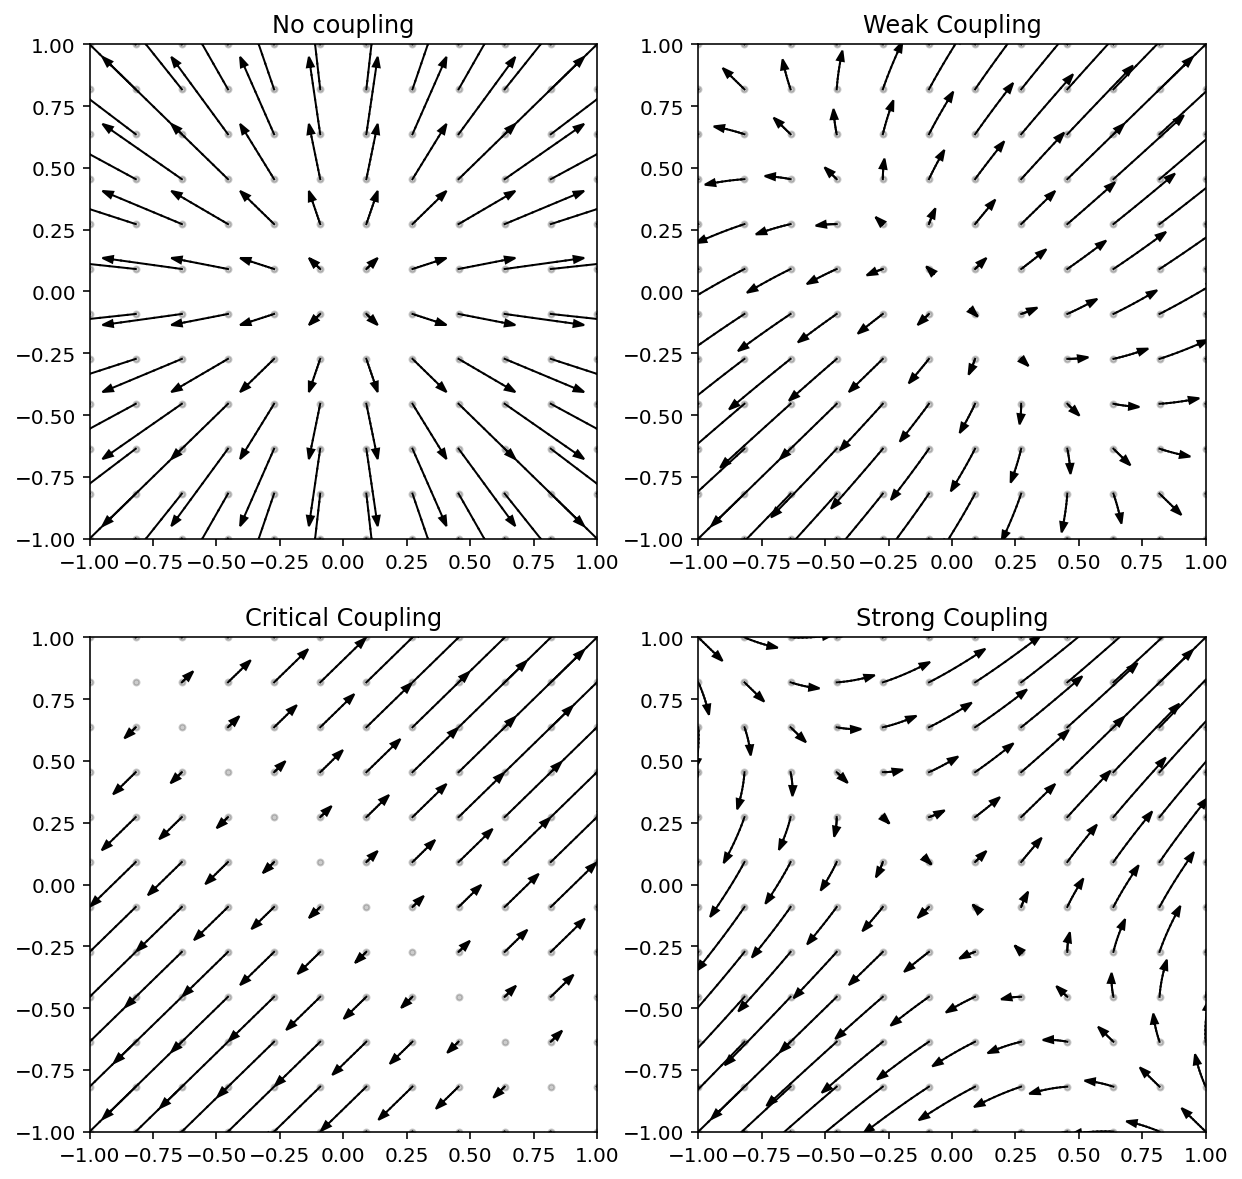

In [60]:
plt.figure(figsize=(10,10))
plotSpace2D(plt.subplot(221, title='No coupling'),coupled_linear_systems, h=0.1, a=0.4, alph=0.00, 
            kx=12, ky=12, steps=10, arrows=9, arrW=0.003)
plotSpace2D(plt.subplot(222, title='Weak Coupling'),coupled_linear_systems, h=0.1, a=0.4, alph=0.15,
            kx=12, ky=12, steps=10, arrows=9, arrW=0.003)
plotSpace2D(plt.subplot(223, title='Critical Coupling'),coupled_linear_systems, h=0.1, a=0.4, alph=0.20,
            kx=12, ky=12, steps=10, arrows=9, arrW=0.003)
plotSpace2D(plt.subplot(224, title='Strong Coupling'),coupled_linear_systems, h=0.1, a=0.4, alph=0.25,
            kx=12, ky=12, steps=10, arrows=9, arrW=0.003)
plt.show()

## Bifurcations

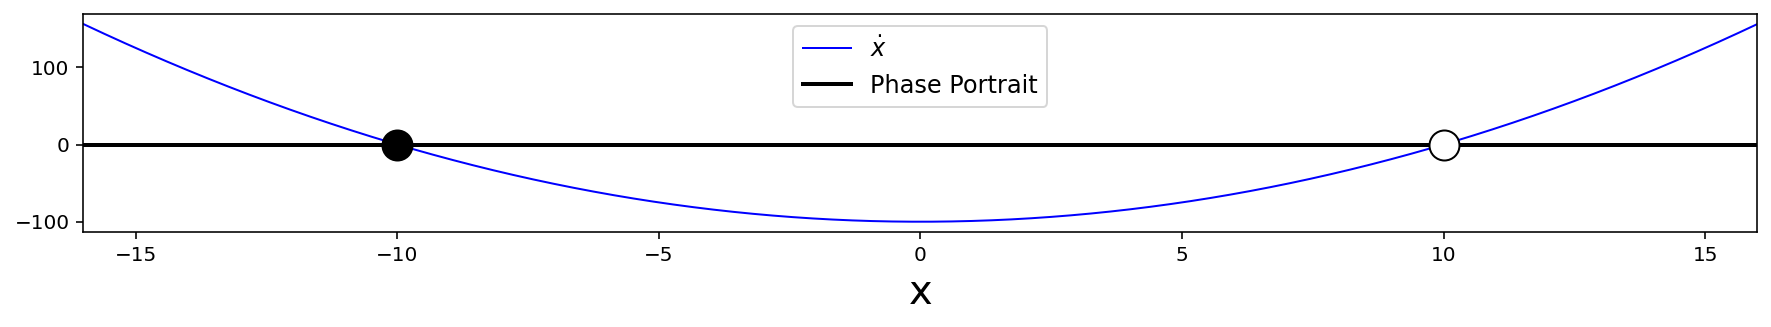

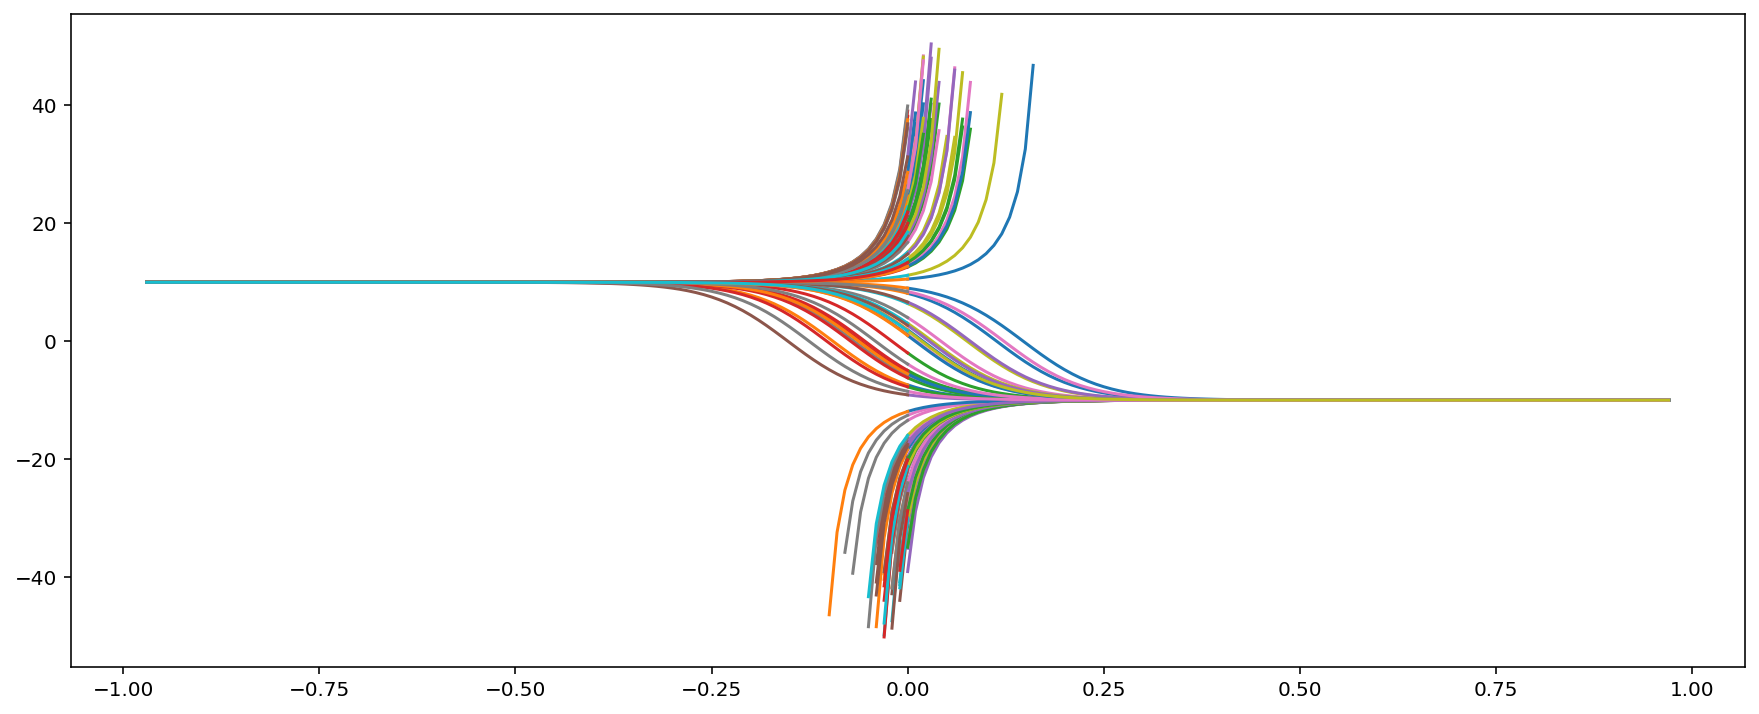

In [18]:
def system(x, t=0, alph=1):
    return x**2 - alph

alph = 100
plotSpace1D(plt.figure(figsize=(15,2)).gca(), system, lims=(-16,16), alph=alph)

points = 80*(np.random.rand(100)-0.5)
h=0.01
steps=100
X = np.empty(steps)

plt.figure(figsize=(15,6))
for point in points:
    X[0] = point
    for k in range(1,steps):
        X[k] = rk4s(system, h, X[k-1], alph=alph)
        if abs(X[k])>1e2 :break
    plt.plot([h*t for t in range(k-1)], X[:k-1])
    for k in range(1,steps):
        X[k] = rk4s(system, -h, X[k-1], alph=alph)
        if abs(X[k])>1e2 :break
    plt.plot([-h*t for t in range(k-1)], X[:k-1])
             

#### Pitchfork Bifurcation

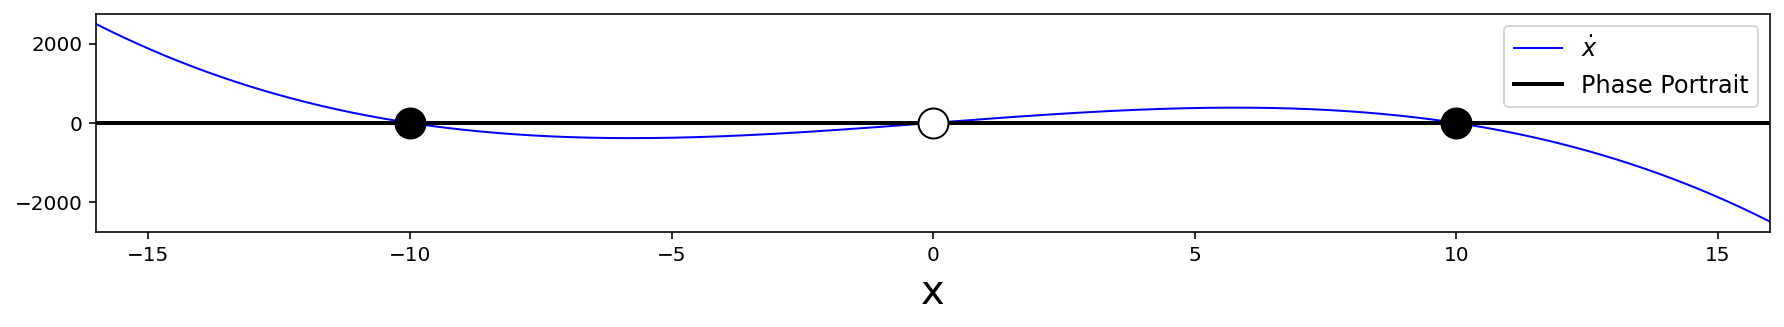

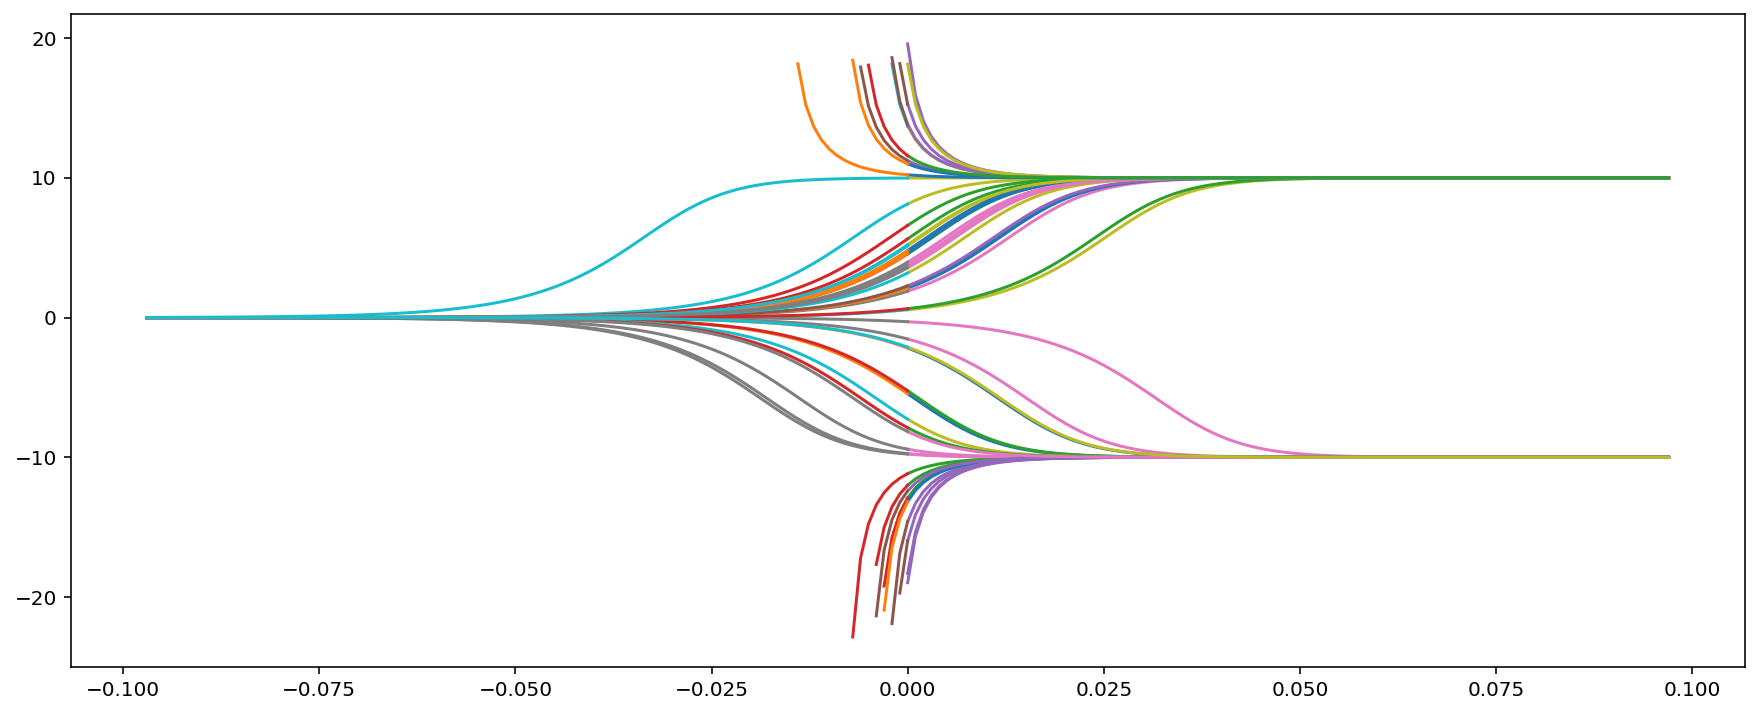

In [68]:
def system(x, t=0, alph=1):
    return alph*x - x**3

alph = 100
plotSpace1D(plt.figure(figsize=(15,2)).gca(), system, lims=(-16,16), alph=alph)

points = 40*(np.random.rand(50)-0.5)
h=0.001
steps=100
X = np.empty(steps)

plt.figure(figsize=(15,6))
for point in points:
    X[0] = point
    for k in range(1,steps):
        X[k] = rk4s(system, h, X[k-1], alph=alph)
        if abs(X[k])>1e2 :break
    plt.plot([h*t for t in range(k-1)], X[:k-1])
    for k in range(1,steps):
        X[k] = rk4s(system, -h, X[k-1], alph=alph)
        if abs(X[k])>1e2 :break
    plt.plot([-h*t for t in range(k-1)], X[:k-1])
             

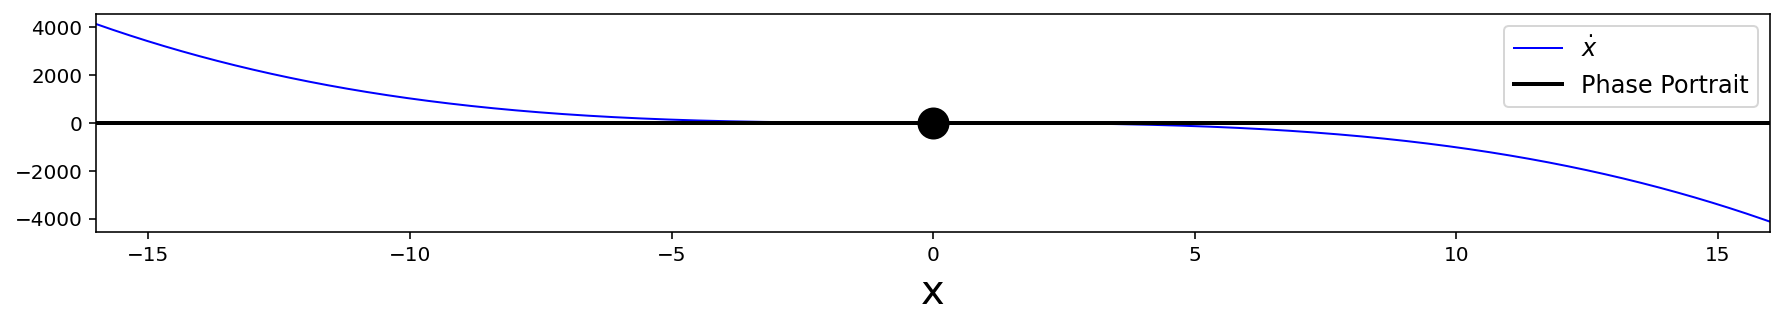

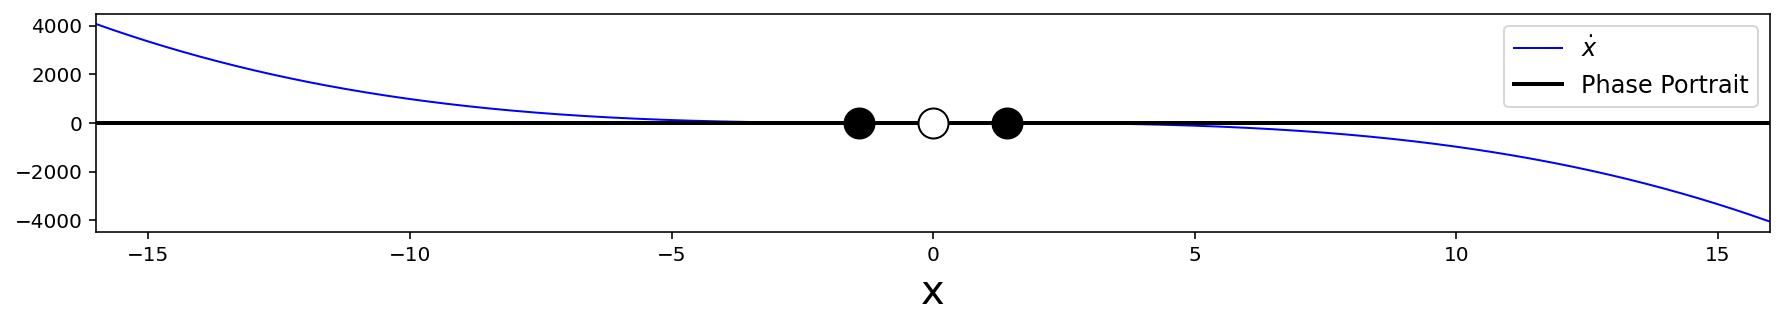

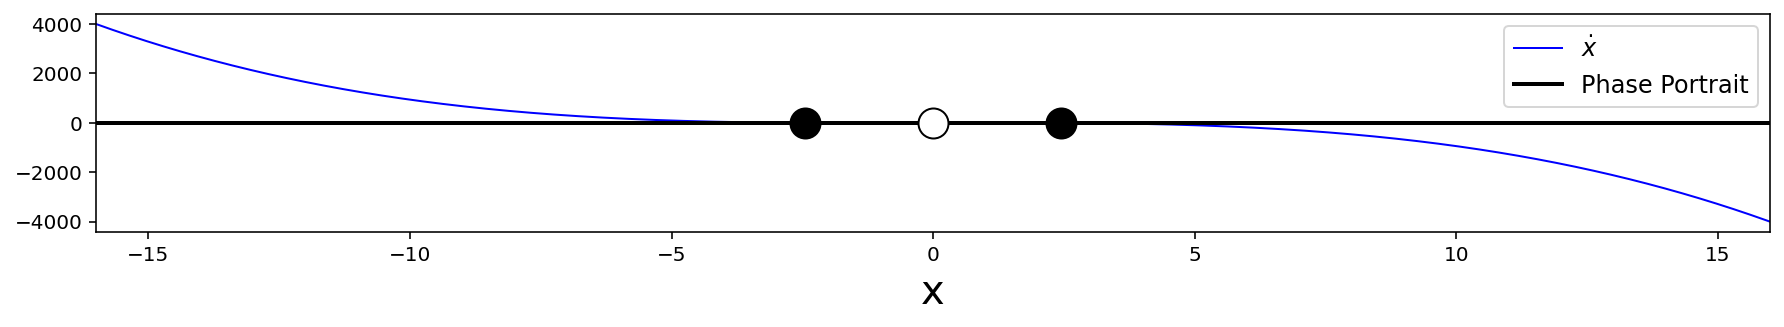

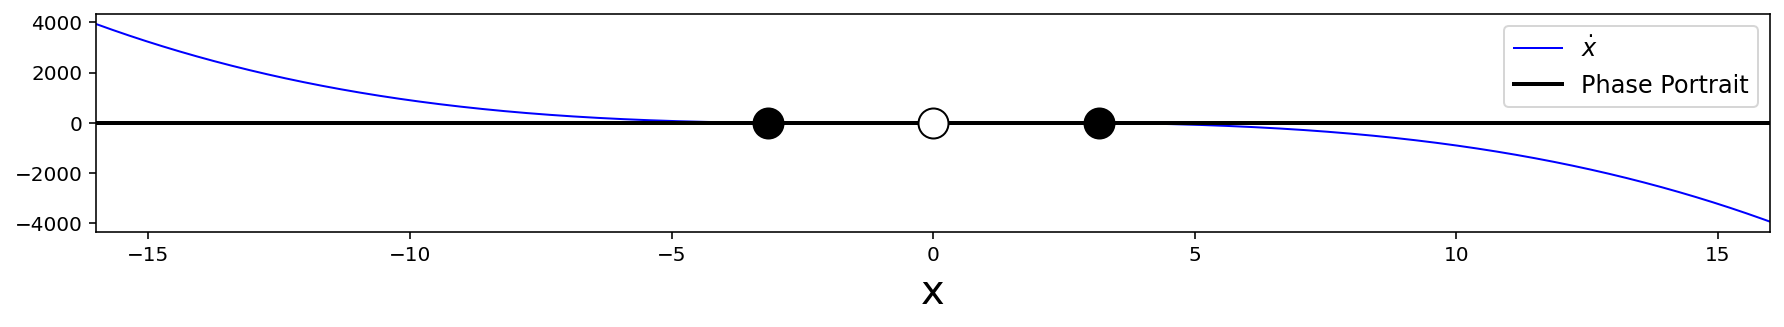

In [76]:
for alph in np.linspace(-2, 10,4):
    plotSpace1D(plt.figure(figsize=(15,2)).gca(), system, lims=(-16,16), alph=alph)

### Hopf Bifurcation

In [54]:
def system(X, t=0, mu=0):
    x,y = X
    xdot = -y + x*(mu-x**2-y**2)
    ydot = x + y*(mu-x**2-y**2)
    return np.array([xdot,ydot])

Plotting 11250 segments
Plotting 11250 segments
Plotting 11250 segments


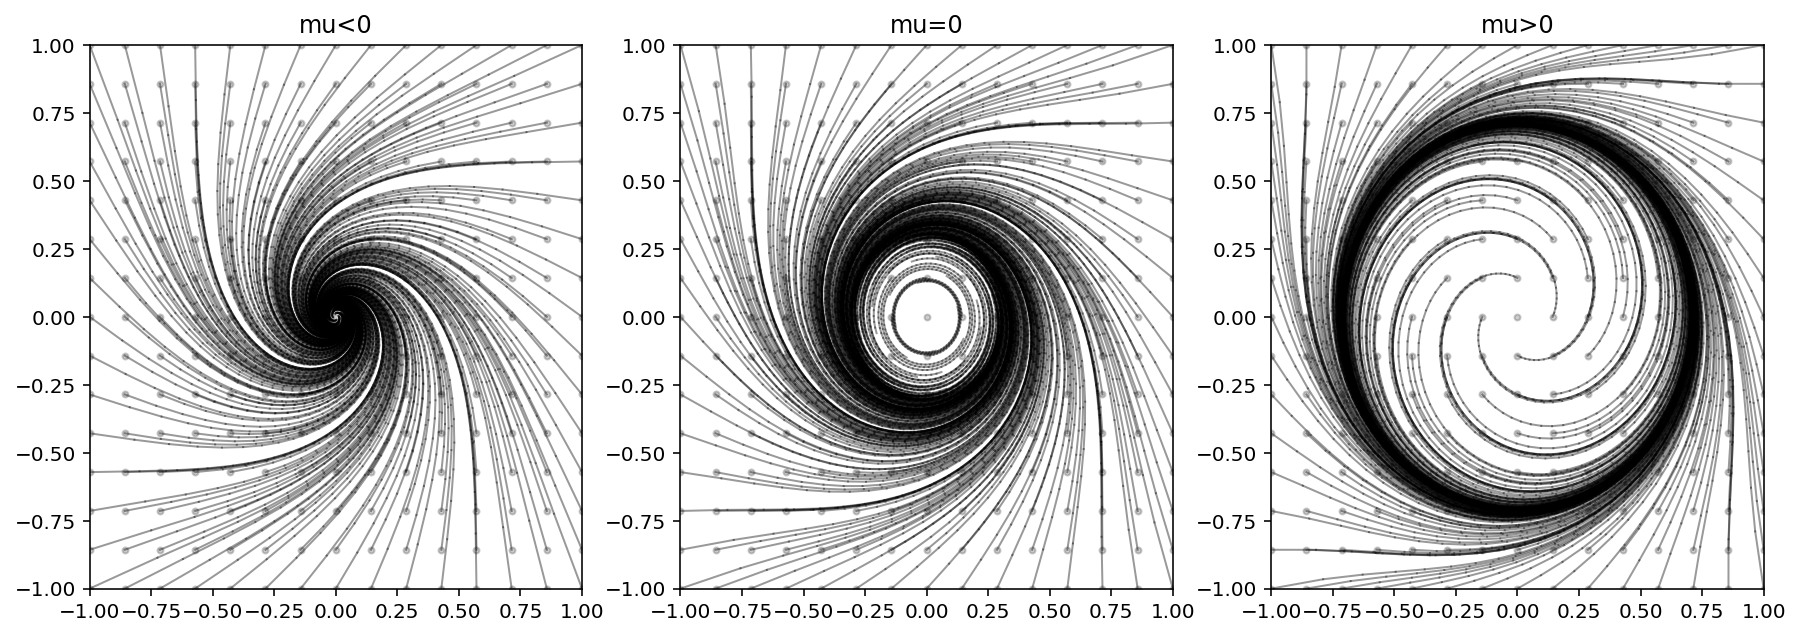

In [55]:
plt.figure(figsize=(15,5))
plotSpace2D(plt.subplot(131, title='mu<0'),system, h=0.1, mu=-.5, 
            kx=15, ky=15, steps=50, arrows=0, alpha=0.4)
plotSpace2D(plt.subplot(132, title='mu=0'),system, h=0.1, mu=0, 
            kx=15, ky=15, steps=50, arrows=0, alpha=0.4)
plotSpace2D(plt.subplot(133, title='mu>0'),system, h=0.1, mu=0.5, 
            kx=15, ky=15, steps=50, arrows=0, alpha=0.4)

### Bifurcation Diagram (Pitchfork Bifurcation)

....................................................................................................

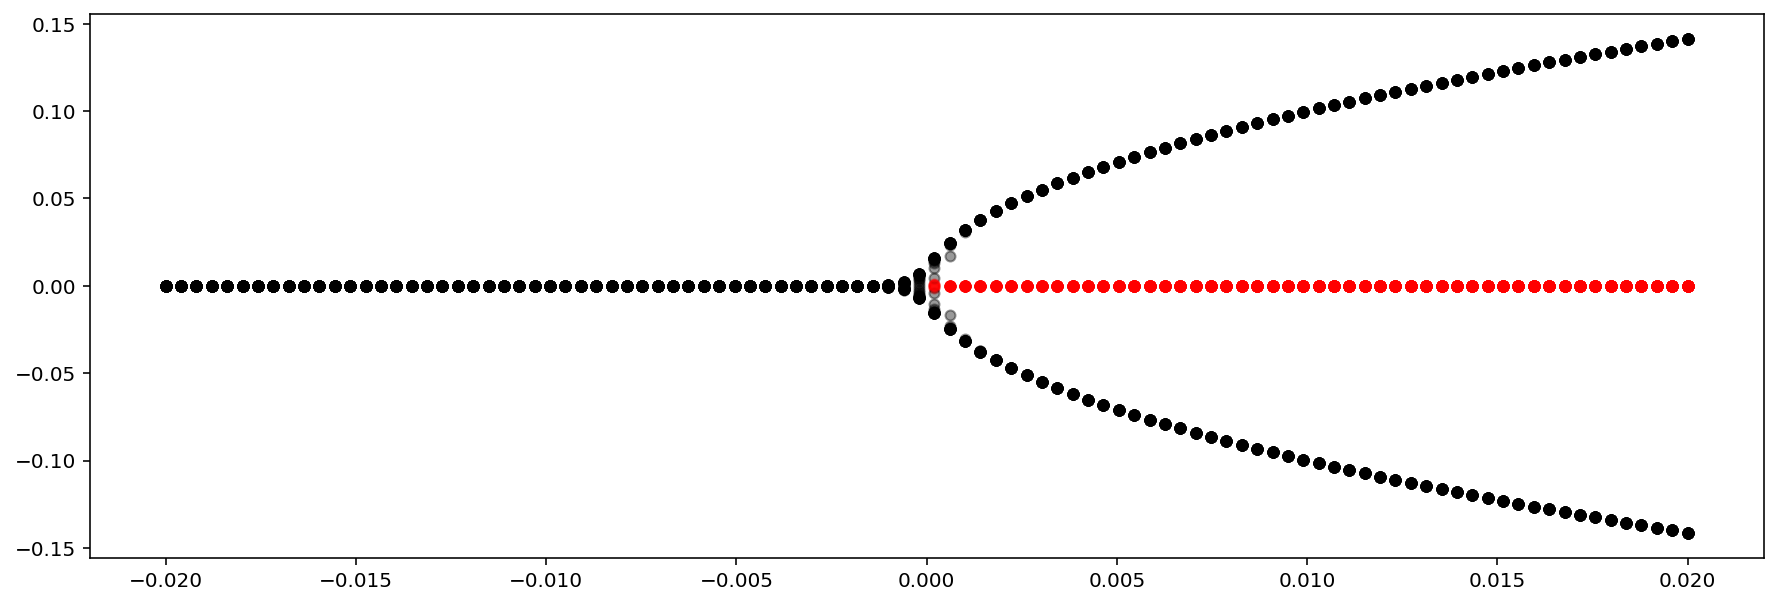

In [67]:
def system(x, t=0, alph=1):
    return alph*x - x**3

steps = 50000
points = np.linspace(-.1,.1,50)
alphas = np.linspace(-0.02, 0.02, 100)

# Warning: Think twice before running this cell with these numbers :)

plt.figure(figsize=(15,5))
for alph in alphas:
    print('.',end='')
    for point in points:
        X = point
        for k in range(1,steps):
            X = rk4s(system, 0.05, X, alph=alph)
            if abs(X)>1: break
        if abs(X)<=1:
            plt.plot(alph, X, 'ok', ms=5, alpha=0.4)
        X = point
        for k in range(1,3*steps):
            X = rk4s(system, -0.05, X, alph=alph)
            if abs(X)>1: break
        if abs(X)<=1:
            plt.plot(alph, X, 'or', ms=5, alpha=0.4)
        
        